# EDA Costos Médicos de Clientes

Este análisis examina la relación entre las características de los clientes y sus costos médicos. Se identifican patrones y posibles predictores clave para estimar los gastos. Los hallazgos ayudan a tomar decisiones basadas en datos para estrategias de atención y presupuesto.

Importamos parte de las librerias que vamos a utilizar y leemos el dataset facilitado y lo guardamos en una variable.

In [52]:
# LIBRERIAS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, f_oneway
import sklearn

In [53]:
total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv")
total_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [54]:
total_data.shape

(1338, 7)

In [55]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


___

Vemos lo que contiene nuestro Dataframe son variables de tipo Float 2 de tipo entero 2 y objeto o categóricas 3

In [56]:
total_data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Aqui verificamos que el dataframe no contenga algun valor nulo.

In [57]:
total_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


Verificaremos que no existan valores duplicados


In [58]:
total_data.duplicated().sum()
total_data = total_data.drop_duplicates().reset_index(drop = True)
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


Dividiremos las variables en numericas y categoricas

In [59]:
num_cols = total_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = total_data.select_dtypes(include=['object']).columns.tolist()

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

Numéricas: ['age', 'bmi', 'children', 'charges']
Categóricas: ['sex', 'smoker', 'region']


Procedemos a analalisar una a una las variables numéricas con sus respectivos gráficos.

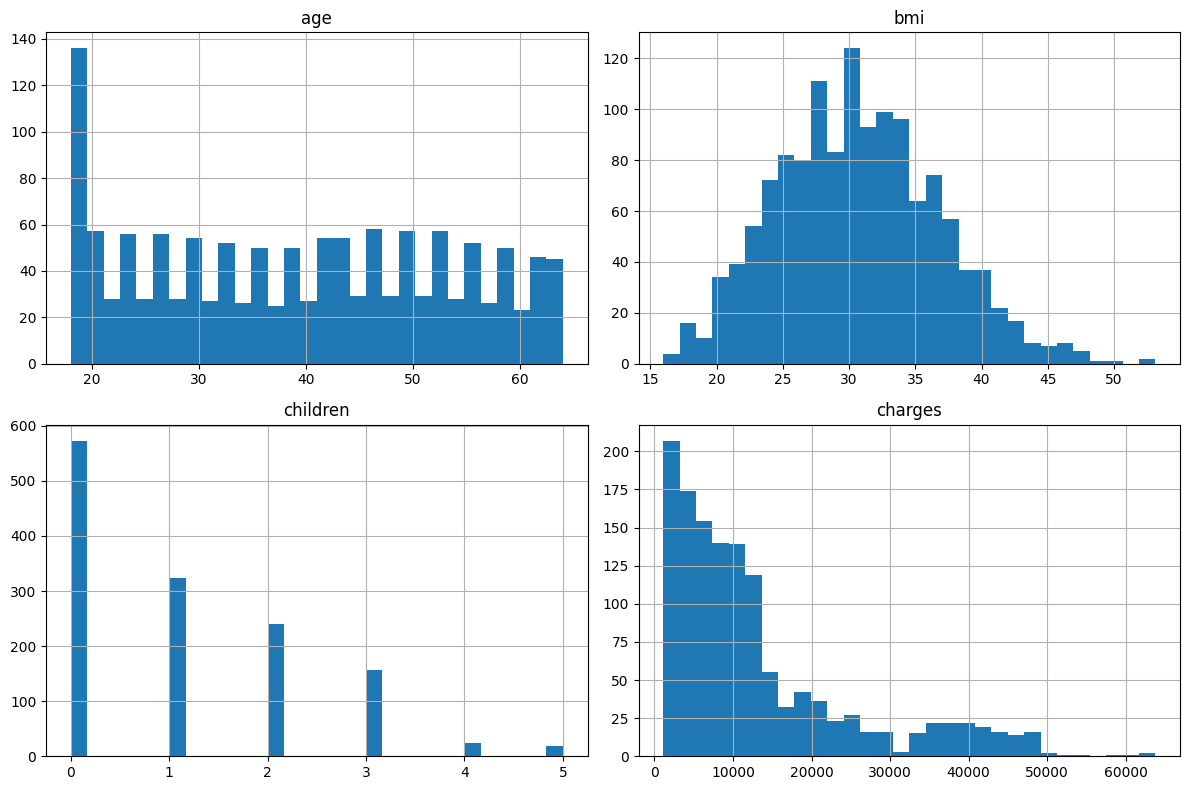

In [60]:
# Histogramas de variables numéricas
total_data[num_cols].hist(figsize=(12,8), bins=30)
plt.tight_layout()
plt.show()



ANALISIS MULTIVARIABLE

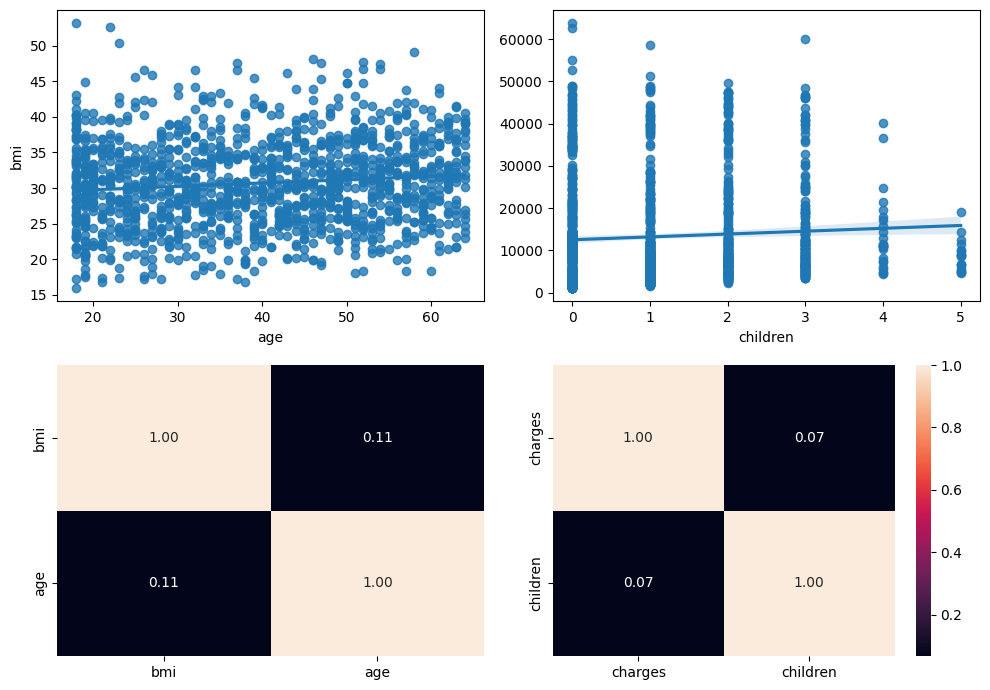

In [61]:
fig, axis = plt.subplots(2, 2, figsize = (10, 7))

# Crear un diagrama de dispersión múltiple
sns.regplot(ax = axis[0, 0], data = total_data, x = "age", y = "bmi")
sns.heatmap(total_data[["bmi", "age"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)
sns.regplot(ax = axis[0, 1], data = total_data, x = "children", y = "charges").set(ylabel=None)
sns.heatmap(total_data[["charges", "children"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()



Análisis mediante mapa de calor.

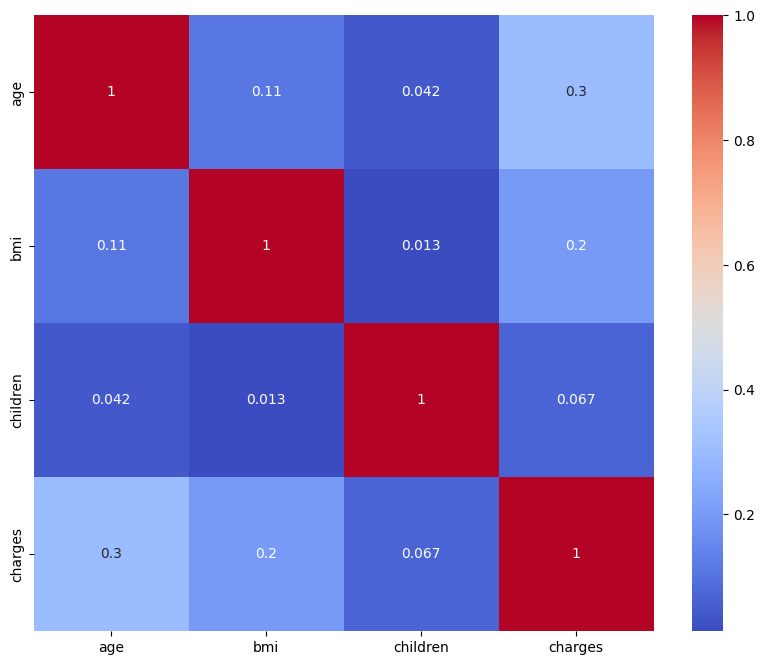

In [62]:
plt.figure(figsize=(10,8))
corr = total_data[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

Podemos evidencuar que no existe alguna co-relación muy fuerte entre las variables númericas salvo por la variable charges (Prima del seguro médico) con las variables Age (edad) y bmi (índice de masa corporal).

___

Deteccion de Outliers:

Aqui lo veremos con gráficos.

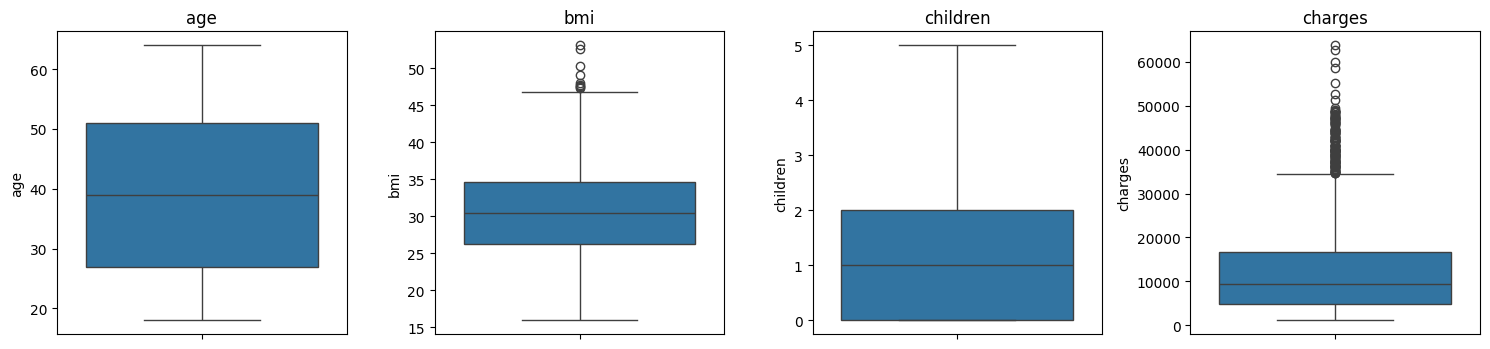

In [63]:
plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 4, i)  # Ajustar filas/columnas según cantidad de variables
    sns.boxplot(y=total_data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

Aqui vemos los outliers por cada columna dentro del Dataset

In [64]:
num_cols = total_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Revisión de outliers por IQR
for col in num_cols:
    Q1 = total_data[col].quantile(0.25)
    Q3 = total_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    outliers_count = ((total_data[col] < lower_limit) | (total_data[col] > upper_limit)).sum()
    print(f"{col}: {outliers_count} outliers")
    

age: 0 outliers
bmi: 9 outliers
children: 0 outliers
charges: 139 outliers


A continuacion lo que realizaremos es una limpieza de outliers no los vamos a eliminar simplemente vamos a reemplazar esos valores para que el analisis no se vea afectado.

In [65]:
# TENEMOS QUE GUARDARNOS TODOS LOS DATASETS, ESTO SIGNIFICA:

total_data_CON_outliers = total_data.copy()

total_data_SIN_outliers = total_data.copy()
# Para cada una de las variables con outliers en mi problema, tengo que reemplazar sus valores del DF

def replace_outliers_from_column(column, df):
  column_stats = df[column].describe()
  column_iqr = column_stats["75%"] - column_stats["25%"]
  upper_limit = column_stats["75%"] + 1.5 * column_iqr
  lower_limit = column_stats["25%"] - 1.5 * column_iqr
  if lower_limit < 0: lower_limit = min(df[column])
  # Remove upper outliers
  df[column] = df[column].apply(lambda x: (x if (x <= upper_limit) else upper_limit) if not pd.isna(x) else np.nan)
  # Remove lower outliers
  df[column] = df[column].apply(lambda x: (x if (x >= lower_limit) else lower_limit) if not pd.isna(x) else np.nan)
  return df.copy(), [lower_limit, upper_limit]

outliers_dict = {}
for column in ['age','bmi', 'children']:
  total_data_SIN_outliers, limit_list = replace_outliers_from_column(column, total_data_SIN_outliers)
  outliers_dict[column] = limit_list

outliers_dict

{'age': [18, np.float64(87.0)],
 'bmi': [np.float64(13.674999999999994), np.float64(47.31500000000001)],
 'children': [0, np.float64(5.0)]}

___

En este bloque de código estamos preparando nuestros datos para poder predecir los costos médicos de los clientes. Primero, definimos qué queremos predecir (charges) y qué información vamos a usar para hacerlo (el resto de las columnas). Luego, convertimos las variables categóricas en números para que el modelo pueda entenderlas.

Después, separamos los datos en entrenamiento y prueba: usamos la mayor parte para que el modelo aprenda y un pequeño grupo para comprobar qué tan bien funciona.

Finalmente, aplicamos una técnica que selecciona las 10 variables más importantes para hacer predicciones, eliminando información que no aporta demasiado. Esto ayuda a que el modelo sea más preciso y fácil de interpretar.

In [66]:

from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif


# 1️⃣ Variable objetivo
y = total_data_SIN_outliers["charges"]  # Aquí usamos la columna 'charges' que dice si el cliente contrató el producto
X = total_data_SIN_outliers.drop(columns=["charges"])  # El resto de columnas como variables predictoras

# 2️⃣ Convertir variables categóricas a numéricas
X = pd.get_dummies(X, drop_first=True)

# 3️⃣ Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4️⃣ Seleccionar las mejores variables
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X_train, y_train)

# 5️⃣ Columnas seleccionadas
selected_columns = X_train.columns[selector.get_support()]
print("Variables seleccionadas:", selected_columns.tolist())

# 6️⃣ DataFrames con solo las variables seleccionadas
X_train_sel = X_train[selected_columns]
X_test_sel = X_test[selected_columns]

Variables seleccionadas: ['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']


C:\Users\isaac\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=8. All the features will be returned.
  warnings.warn(
C:\Users\isaac\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)


___

En este bloque estamos construyendo un modelo de regresión lineal, que es un modelo que aprende a predecir un valor numérico (en este caso, los costos médicos) a partir de varias características de los clientes.

Primero creamos el modelo y lo entrenamos con los datos seleccionados, para que aprenda las relaciones entre las variables predictoras y la variable objetivo. Luego, usamos el modelo para hacer predicciones sobre los datos de prueba, que no ha visto antes, para evaluar qué tan bien funciona.

Finalmente, calculamos métricas como el error cuadrático medio (MSE), la raíz del error cuadrático medio (RMSE) y el R², que nos indican qué tan precisas son las predicciones y qué proporción de la variabilidad de los datos el modelo puede explicar.

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1️⃣ Crear el modelo de regresión lineal
linear_model = LinearRegression()

# 2️⃣ Entrenar el modelo con los datos seleccionados
linear_model.fit(X_train_sel, y_train)

# 3️⃣ Predecir sobre el conjunto de test
y_pred = linear_model.predict(X_test_sel)

# 4️⃣ Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("Error cuadrático medio (MSE):", mse)
print("Raíz del error cuadrático medio (RMSE):", rmse)
print("R² (explicación de la varianza):", r2)

Error cuadrático medio (MSE): 35452902.11435881
Raíz del error cuadrático medio (RMSE): 5954.233965369417
R² (explicación de la varianza): 0.8070654032596751


“El modelo de regresión lineal logra explicar aproximadamente el 81% del comportamiento de los costos médicos, y sus predicciones tienen un error promedio de alrededor de 5,954 unidades. Esto nos da una base confiable para estimar los costos futuros según las características de los clientes.”